##  Step 1: Import libraries
- os: Handles file paths and directory operations, like navigating and loading files.
- torch: PyTorch library for deep learning, used for computations and running models on GPUs.
- torchvision.transforms: Prepares and preprocesses images (e.g., resizing, normalizing) for the model.
- PIL: Reads and manipulates images in formats like JPEG and PNG.
- clip: OpenAI’s library for the CLIP model, used to link images and text for predictions.
- matplotlib.pyplot: Creates visualizations, such as plots of class probabilities or results.


In [1]:
import os
import torch
from torchvision import transforms
from PIL import Image
import clip 
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns



##  Step 2: Set up the device
Let's check if a GPU is available and set it up for training.
Explanation: If a GPU is available that means the speed of training the model will increase, but if not it defaults to the CPU.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the CLIP model and its tokenizer
model, preprocess = clip.load("ViT-B/32", device=device)



## Step 3: Verify Dataset and Classes
## Dataset Verification
The dataset is stored in labeled folders for each art style. Below, we verify that the dataset is correctly structured and display the number of images in each folder.



In [3]:
import os
import shutil

# Path to dataset
dataset_dir = "images"

if os.path.exists(dataset_dir):
    print(f"Dataset path exists: {dataset_dir}")
    subdirs = os.listdir(dataset_dir)
    
    for subdir in subdirs:
        subdir_path = os.path.join(dataset_dir, subdir)
        num_images = len(os.listdir(subdir_path))
        
        if num_images == 0:
            # Remove the folder with 0 images
            print(f"Removing empty class: {subdir}")
            shutil.rmtree(subdir_path)
        else:
            print(f"Class: {subdir}, Images: {num_images}")
else:
    print(f"Dataset path does not exist: {dataset_dir}")


Dataset path exists: images
Removing empty class: 2nd_intermediate_period
Removing empty class: 3rd_intermediate_period
Class: abstract_art, Images: 7
Class: abstract_expressionism, Images: 1
Class: academicism, Images: 8
Class: amarna, Images: 1
Removing empty class: american_realism
Removing empty class: ancient_egyptian_art
Removing empty class: ancient_greek_art
Class: archaic, Images: 3
Class: art_deco, Images: 12
Class: baroque, Images: 4
Class: biedermeier, Images: 2
Removing empty class: chernihiv_school
Class: classical, Images: 40
Class: classicism, Images: 40
Removing empty class: cloisonnism
Class: constructivism, Images: 7
Class: contemporary_art, Images: 6
Removing empty class: coptic_art
Removing empty class: costumbrismo
Removing empty class: cretan_school
Removing empty class: crusader_workshop
Class: cubism, Images: 3
Class: digital_art, Images: 4
Class: divisionism, Images: 1
Removing empty class: early_byzantine
Removing empty class: early_christian
Class: early_dyn

## Step 4: Fine-Tune with CLIP model
1.  Prepare Image Features



In [8]:
def extract_features(image_path):
    # Open image
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    return image

# Sample path
image_path = "C:/Users/laris/kalibro_project/louvre.jpg"  
image_features = extract_features(image_path)


2. Class Labels

In [13]:
# Define the classes in your dataset
class_labels = [
    "Abstract Art", "Cubism", "Impressionism", "Baroque", "Renaissance",
    "Surrealism", "Pop Art", "Expressionism", "Minimalism", "Romanticism",
    "Art Nouveau", "Fauvism", "Realism", "Symbolism", "Art Deco",
    "Pointillism", "Divisionism", "Constructivism", "Photorealism",
    "Graffiti Art", "Street Art", "Digital Art", "Fantasy Art", 
    "Neo-Expressionism", "Abstract Expressionism", "Op Art", 
    "Post-Impressionism", "Classicism", "Tenebrism", "Mannerism",
    "Naïve Art", "Regionalism", "Socialist Realism", "Metaphysical Art",
    "Cartographic Art", "Feminist Art", "Contemporary Art", 
    "Hyper-Realism", "Tonalism", "Kitsch", "Magic Realism", 
    "Fantastic Realism", "Hyper-Mannerism", "Conceptual Art", 
    "Lyrical Abstraction", "Hard Edge Painting", "Color Field Painting",
    "Dada", "Futurism", "Precisionism", "Orphism", "Constructivism",
    "Neo-Pop Art", "Graffiti Art", "Lowbrow Art", "Modern Art"
]

# Tokenize class labels
text_inputs = torch.cat([clip.tokenize(f"a painting in the style of {label}") for label in class_labels]).to(device)


3. Prediction

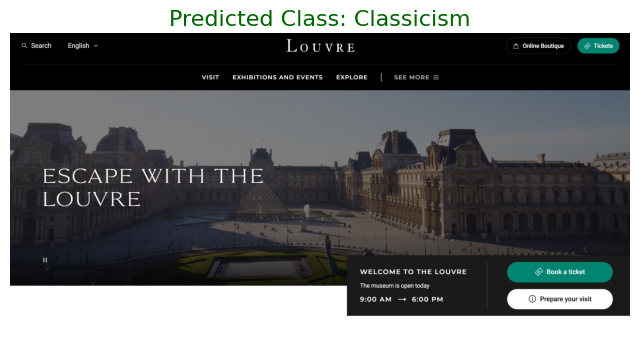

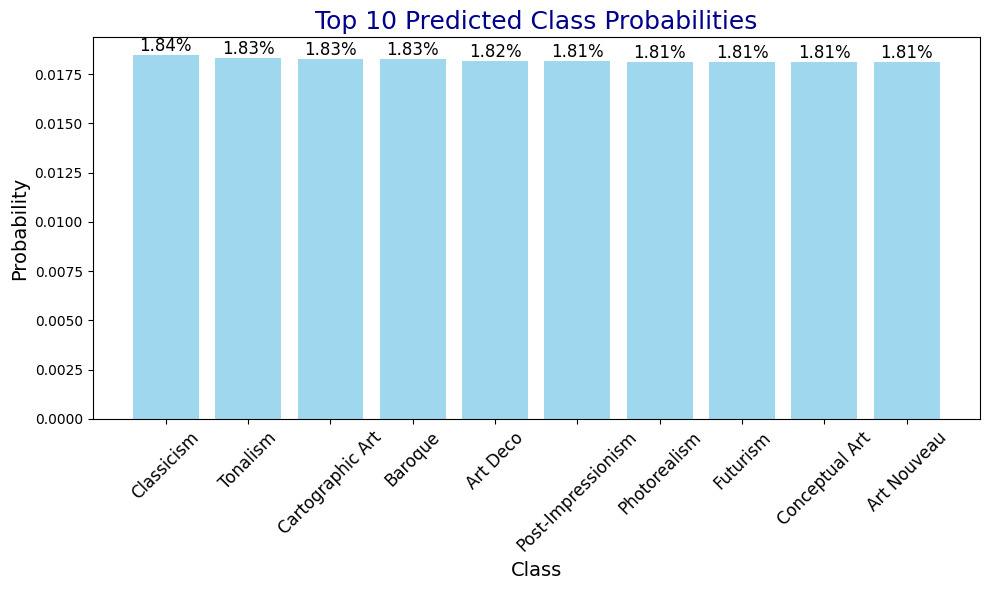

In [14]:

with torch.no_grad():
    # Preprocess the input image
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    
    # Encode image and text
    image_features = model.encode_image(image)
    text_features = model.encode_text(text_inputs)

    # Normalize the features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Compute similarity
    similarity = (image_features @ text_features.T).squeeze(0)  # Cosine similarity
    probs = similarity.softmax(dim=-1).cpu().numpy()

# Get the predicted class
predicted_class = class_labels[np.argmax(probs)]

# Display the input image with the predicted class
plt.figure(figsize=(8, 8))
img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted Class: {predicted_class}", fontsize=16, color='darkgreen')
plt.show()

# Limit the display to the top N most probable classes
top_n = 10  # Change this to display more or fewer classes
sorted_indices = np.argsort(probs)[::-1][:top_n]
sorted_labels = [class_labels[i] for i in sorted_indices]
sorted_probs = probs[sorted_indices]

# Plot the top N class probabilities
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_labels, sorted_probs, color='skyblue', alpha=0.8)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.title(f"Top {top_n} Predicted Class Probabilities", fontsize=18, color='darkblue')
plt.xticks(rotation=45, fontsize=12)

# Add percentage labels above each bar
for bar, prob in zip(bars, sorted_probs):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f"{prob:.2%}", ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()

